In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import copy
from itertools import permutations, combinations

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

# Functions from 07e* notebooks
import utils_07


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Exemplary computation for one task

In [2]:
import copy

def get_df_with_attributions(task):
    df = utils_07.get_miniabsolut_dataframes(task)
    df_attr = pd.DataFrame.from_records(task.attributions)

    if "expits" in df_attr.columns:
        cols_to_merge = ["slide", "logits", "expits", "y_pred", "y_true", "is_pred_correct"]
    else:
        cols_to_merge = ["slide", "logits"]

    df = pd.merge(df, df_attr[cols_to_merge], left_on="Slide", right_on="slide", how='left')
    return df

tasks = list(utils_07.task_generator())

# Workflow per task from here on.
task = tasks[-1]
print(task)
task_linear = copy.deepcopy(task)
task_nonlinear = copy.deepcopy(task)

# Get linear
linear_loader = loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_Linear_ML/")
)
linear_loader.load(task_linear, attributions_toload="v0.1.2-3")
linear_df = get_df_with_attributions(task_linear)

# Get nonlinear
nonlinear_loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)
nonlinear_loader.load(task_nonlinear, attributions_toload="v2.0-2")
nonlinear_df = get_df_with_attributions(task_nonlinear)

ONE_VS_ONE__1OB1__2YPV__0__4


FileNotFoundError: [Errno 2] No such file or directory: '../data/Frozen_MiniAbsolut_Linear_ML/1v1/seed_0/split_4/1OB1__vs__2YPV/swa_model/data/model.pth'

In [ ]:
linear_df

,Unnamed: 0,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,Source,Antigen,class,slide,logits
0,19131,1449228_03a,CARWELGRYWYFDVW,True,WELGRYWYFDV,-92.62,149471-DUDLULLRLR,mascotte,1OB1,positive,WELGRYWYFDV,1.518164
1,5443,537240_00a,CAYYGVLLFDVW,True,CAYYGVLLFDV,-94.11,149471-DUDLULLRLR,mascotte,1OB1,positive,CAYYGVLLFDV,2.375696
2,26974,2874075_00a,CALLGLRRFAYW,True,CALLGLRRFAY,-94.71,149471-DUDLULLRLR,mascotte,1OB1,positive,CALLGLRRFAY,3.406729
3,6493,719721_04a,CARKAVLWRFYAMDYW,True,AVLWRFYAMDY,-92.53,149471-DUDLULLRLR,mascotte,1OB1,positive,AVLWRFYAMDY,-0.023569
4,26213,6483168_01a,CARIGPLLGFDVW,True,ARIGPLLGFDV,-94.28,149471-DUDLULLRLR,mascotte,1OB1,positive,ARIGPLLGFDV,0.892724
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120307,1565792_03a,CARRAYRFVGYFDVW,True,RAYRFVGYFDV,-88.64,153631-DUDUDDRDLR,looserX,1OB1,negative,RAYRFVGYFDV,-1.563310
9996,130378,1701440_03a,CARLGIYYDYDVNW,True,LGIYYDYDVNW,-90.37,149536-DUDDRDLRDU,looserX,1OB1,negative,LGIYYDYDVNW,-2.090100
9997,146658,3241199_00a,CARLRLLGYYW,True,CARLRLLGYYW,-92.06,149536-DUDDRDLRDU,looserX,1OB1,negative,CARLRLLGYYW,0.327835
9998,13374,1971289_02a,CVRHLKLGGYFDVW,True,RHLKLGGYFDV,-89.92,153631-DRLUDLULLR,looserX,1OB1,negative,RHLKLGGYFDV,-2.814061


In [ ]:
nonlinear_df

,Unnamed: 0,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,Source,Antigen,class,slide,logits,expits,y_pred,y_true,is_pred_correct
0,19131,1449228_03a,CARWELGRYWYFDVW,True,WELGRYWYFDV,-92.62,149471-DUDLULLRLR,mascotte,1OB1,positive,WELGRYWYFDV,1.194526,0.767549,1,1,True
1,5443,537240_00a,CAYYGVLLFDVW,True,CAYYGVLLFDV,-94.11,149471-DUDLULLRLR,mascotte,1OB1,positive,CAYYGVLLFDV,1.966353,0.877219,1,1,True
2,26974,2874075_00a,CALLGLRRFAYW,True,CALLGLRRFAY,-94.71,149471-DUDLULLRLR,mascotte,1OB1,positive,CALLGLRRFAY,3.247685,0.962590,1,1,True
3,6493,719721_04a,CARKAVLWRFYAMDYW,True,AVLWRFYAMDY,-92.53,149471-DUDLULLRLR,mascotte,1OB1,positive,AVLWRFYAMDY,-0.739973,0.323010,0,1,False
4,26213,6483168_01a,CARIGPLLGFDVW,True,ARIGPLLGFDV,-94.28,149471-DUDLULLRLR,mascotte,1OB1,positive,ARIGPLLGFDV,2.751859,0.940018,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120307,1565792_03a,CARRAYRFVGYFDVW,True,RAYRFVGYFDV,-88.64,153631-DUDUDDRDLR,looserX,1OB1,negative,RAYRFVGYFDV,-9.478966,0.000076,0,0,True
9996,130378,1701440_03a,CARLGIYYDYDVNW,True,LGIYYDYDVNW,-90.37,149536-DUDDRDLRDU,looserX,1OB1,negative,LGIYYDYDVNW,-3.415605,0.031811,0,0,True
9997,146658,3241199_00a,CARLRLLGYYW,True,CARLRLLGYYW,-92.06,149536-DUDDRDLRDU,looserX,1OB1,negative,CARLRLLGYYW,-0.669088,0.338701,0,0,True
9998,13374,1971289_02a,CVRHLKLGGYFDVW,True,RHLKLGGYFDV,-89.92,153631-DRLUDLULLR,looserX,1OB1,negative,RHLKLGGYFDV,-7.634731,0.000483,0,0,True


In [ ]:
df = pd.merge(linear_df, nonlinear_df, on=["Slide"], suffixes=("_linear", "_nonlinear"))
df["is_pred_correct_nonlinear"] = df["is_pred_correct"]
df["is_pred_correct_linear"] = (
    (
        (df["is_pred_correct_nonlinear"] == True)
        & ((df["logits_linear"] >= 0) == (df["logits_nonlinear"] >= 0))
    )
    | (
        (df["is_pred_correct_nonlinear"] == False)
        & ((df["logits_linear"] >= 0) != (df["logits_nonlinear"] >= 0))
    )
)
df["same_mistake"] = (
    (df["is_pred_correct_nonlinear"] == False)
    & (df["is_pred_correct_linear"] == False)
)
df["nonlinear_better"] = (
    (df["is_pred_correct_nonlinear"] == True)
    & (df["is_pred_correct_linear"] == False)
)
df["linear_better"] = (
    (df["is_pred_correct_nonlinear"] == False)
    & (df["is_pred_correct_linear"] == True)
)
# Same prediction + correct
df["same_prediction"] = (
    (df["is_pred_correct_nonlinear"] == True)
    & (df["is_pred_correct_linear"] == True)
)

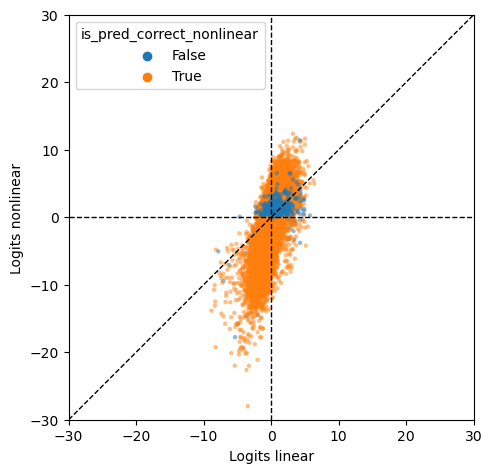

In [ ]:
# Scatter plot logits linear vs nonlinear with
#  same axis on y and x and a plotted diagonal.
#  Also plot the difference between the two.
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=df,
    x="logits_linear",
    y="logits_nonlinear",
    ax=ax,
    alpha=0.5,
    linewidth=0,
    s=10,
    color="black",
    hue="is_pred_correct_nonlinear",
)
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_xlabel("Logits linear")
ax.set_ylabel("Logits nonlinear")
ax.plot([-30, 30], [-30, 30], color="black", linewidth=1, linestyle="--")
ax.axvline(0, color="black", linewidth=1, linestyle="--")
ax.axhline(0, color="black", linewidth=1, linestyle="--")
ax.set_aspect("equal", "box")
fig.tight_layout()

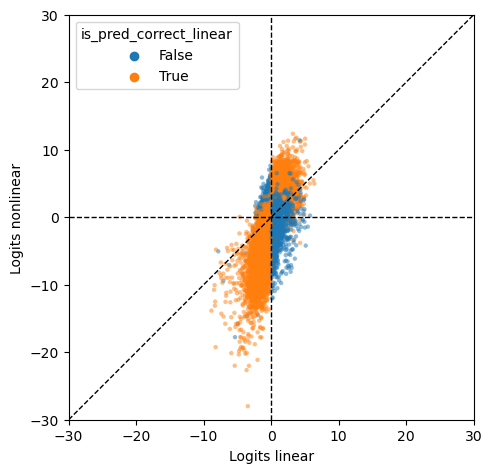

In [ ]:
# Scatter plot logits linear vs nonlinear with
#  same axis on y and x and a plotted diagonal.
#  Also plot the difference between the two.
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=df,
    x="logits_linear",
    y="logits_nonlinear",
    ax=ax,
    alpha=0.5,
    linewidth=0,
    s=10,
    color="black",
    hue="is_pred_correct_linear",
)
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_xlabel("Logits linear")
ax.set_ylabel("Logits nonlinear")
ax.plot([-30, 30], [-30, 30], color="black", linewidth=1, linestyle="--")
ax.axvline(0, color="black", linewidth=1, linestyle="--")
ax.axhline(0, color="black", linewidth=1, linestyle="--")
ax.set_aspect("equal", "box")
fig.tight_layout()

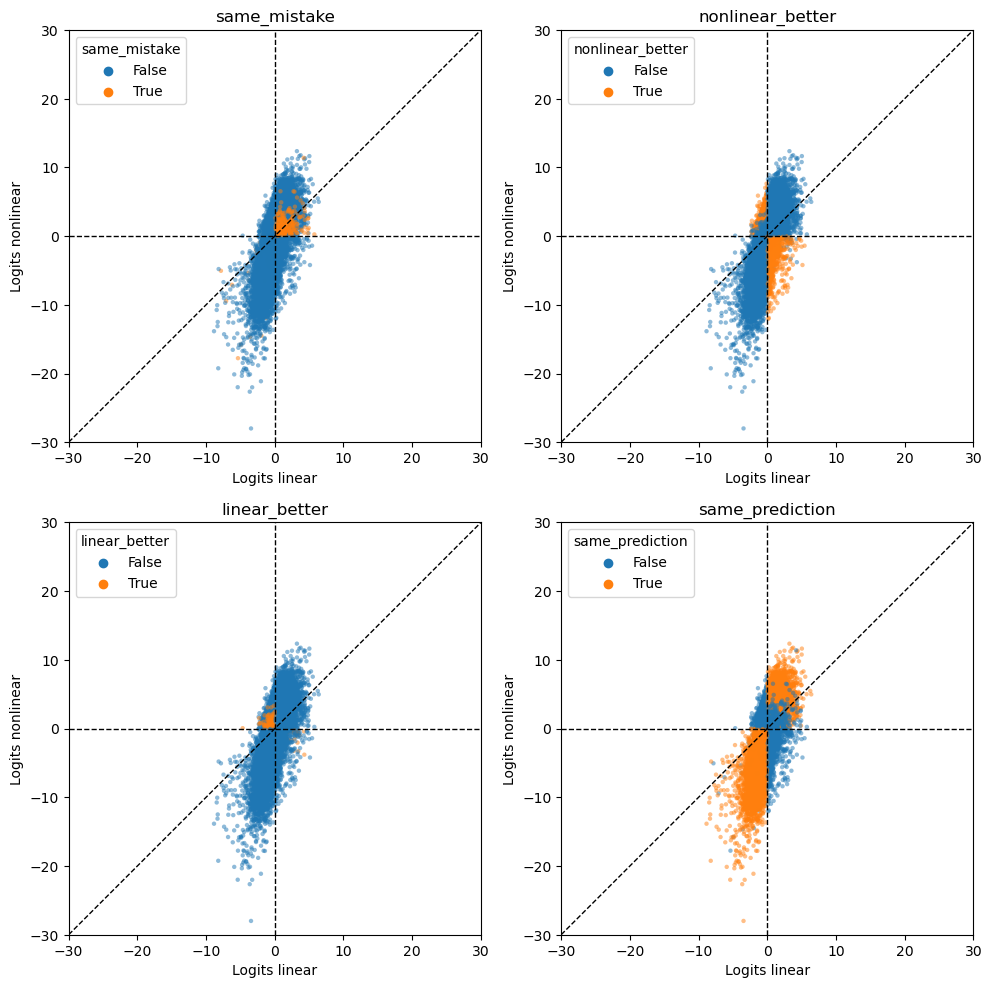

In [ ]:
# Make a plot with 4 figures,
#  that include same_mistake, nonlinear_better, linear_better, same_prediction
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, (ax, col) in enumerate(zip(axs, ["same_mistake", "nonlinear_better", "linear_better", "same_prediction"])):
    sns.scatterplot(
        data=df,
        x="logits_linear",
        y="logits_nonlinear",
        ax=ax,
        alpha=0.5,
        linewidth=0,
        s=10,
        color="black",
        hue=col,
    )
    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 30)
    ax.set_xlabel("Logits linear")
    ax.set_ylabel("Logits nonlinear")
    ax.plot([-30, 30], [-30, 30], color="black", linewidth=1, linestyle="--")
    ax.axvline(0, color="black", linewidth=1, linestyle="--")
    ax.axhline(0, color="black", linewidth=1, linestyle="--")
    ax.set_aspect("equal", "box")
    ax.set_title(col)

fig.tight_layout()


In [ ]:
r_pos, p_pos = pearsonr(
    df[(df["y_true"] == 1) & (df["nonlinear_better"])]["logits_nonlinear"],
    df[(df["y_true"] == 1) & (df["nonlinear_better"])]["Energy_nonlinear"],
)
print(f"r_pos: {r_pos:.3f}, p_pos: {p_pos:.3f}")

print(f"Nonlinear better: {df['nonlinear_better'].sum()/df.shape[0]}")
print(f"Nonlinear better logit: {df[df['nonlinear_better']]['logits_nonlinear'].mean()}")

r_pos: -0.454, p_pos: 0.000
Nonlinear better: 0.1766
Nonlinear better logit: -0.43898898471117287


In [ ]:
df["nonlinear_better"].sum()

1766

Nonlinear does more confident predictions.

In [ ]:
(abs(df["logits_nonlinear"]) / abs(df["logits_linear"])).describe()

count    10000.000000
mean        19.126645
std        487.724081
min          0.000209
25%          1.773453
50%          3.440646
75%          6.430606
max      42367.929293
dtype: float64

Diamonoacid frequencies didn't show strong patterns/results:

In [ ]:
def compute_diaminoacid_freq(slide_list):

    # Create a list of all possible amino acid and index combinations
    aa_indeces = []
    for aa in config.AMINOACID_ALPHABET:
        for i in range(0, 11):
            aa_indeces.append(utils_07.AA_Index(aa, i))

    aaidx_pairs = list(combinations(aa_indeces, 2))

    # Compute diaminoacid frequencies from slide_list
    records = []
    for slide in slide_list:
        
        aaidxs = {}    
        for pair in aaidx_pairs:
            if pair[0].isin_str(slide) and pair[1].isin_str(slide):
                aaidxs[f"{pair[0]}_{pair[1]}"] = 1
            else:
                aaidxs[f"{pair[0]}_{pair[1]}"] = 0
        
        record = {
            "slide": slide,
            **aaidxs,
        }
        records.append(record)

    # Represent as df
    df_aaidx = pd.DataFrame.from_records(records)
    df_aaidx.set_index("slide", inplace=True)
    return df_aaidx

In [ ]:
# # from scipy.special import expit
# # expit(-3)

# # Select slides with possible non-linear effect
# slide_special_list = df[df["nonlinear_better"] & (df["logits_nonlinear"] < -3)]["Slide"].tolist()
# df_aaidx_sp = compute_diaminoacid_freq(slide_special_list)
# # (df_aaidx_sp.sum(axis=0) / df_aaidx_sp.shape[0]).sort_values(ascending=False)

# # Select all other slides
# slide_other_list = df[(df["Slide"].isin(slide_special_list) == False) & (df["y_true"] == 0)]["Slide"].tolist()
# df_aaidx = compute_diaminoacid_freq(slide_other_list)

# (df_aaidx_sp.sum(axis=0) - df_aaidx.sum(axis=0)).plot.hist()

KeyboardInterrupt: 

In [ ]:
# (df_aaidx_sp.sum(axis=0)/df_aaidx_sp.shape[0] - df_aaidx.sum(axis=0) / df_aaidx.shape[0]).sort_values(ascending=False)

L:2_W:10    0.120427
L:4_W:10    0.120241
L:4_L:5     0.107739
F:8_L:5     0.106611
D:8_L:4     0.100092
              ...   
G:5_Y:4    -0.032098
G:6_Y:9    -0.034935
W:8_Y:9    -0.042913
F:10_W:8   -0.043344
F:10_Y:9   -0.047531
Length: 24090, dtype: float64

In [ ]:
# (df_aaidx_sp.sum(axis=0)/df_aaidx_sp.shape[0] - df_aaidx.sum(axis=0) / df_aaidx.shape[0]).plot.hist()

Compute some metrics to capture the patterns from previous plots.

In [ ]:
df["y_pred_nonlinear"] = df["logits_nonlinear"] > 0
df["y_pred_linear"] = df["logits_linear"] > 0

# Compute sensitivity, specificity, accuracy, precision, recall, f1 for linear and nonlinear
#  predictions

df_metrics = pd.DataFrame()
for y_pred in ["y_pred_linear", "y_pred_nonlinear"]:
    df_metrics.loc["dataset", f"{y_pred}_accuracy"] = accuracy_score(df["y_true"], df[y_pred]) # type: ignore
    df_metrics.loc["dataset", f"{y_pred}_precision"] = precision_score(df["y_true"], df[y_pred]) # type: ignore
    df_metrics.loc["dataset", f"{y_pred}_recall"] = recall_score(df["y_true"], df[y_pred]) # type: ignore
    df_metrics.loc["dataset", f"{y_pred}_f1"] = f1_score(df["y_true"], df[y_pred]) # type: ignore

    tn, fp, fn, tp = confusion_matrix(df["y_true"], df[y_pred]).ravel()

    df_metrics.loc["dataset", f"{y_pred}_specificity"] = tn / (tn + fp)
    df_metrics.loc["dataset", f"{y_pred}_sensitivity"] = tp / (tp + fn)

    # Add tpr, fpr, tnr, fnr
    df_metrics.loc["dataset", f"{y_pred}_tpr"] = tp / (tp + fn)
    df_metrics.loc["dataset", f"{y_pred}_fpr"] = fp / (fp + tn)
    df_metrics.loc["dataset", f"{y_pred}_tnr"] = tn / (tn + fp)
    df_metrics.loc["dataset", f"{y_pred}_fnr"] = fn / (fn + tp)
    

In [ ]:
df_metrics

,y_pred_linear_accuracy,y_pred_linear_precision,y_pred_linear_recall,y_pred_linear_f1,y_pred_linear_specificity,y_pred_linear_sensitivity,y_pred_linear_tpr,y_pred_linear_fpr,y_pred_linear_tnr,y_pred_linear_fnr,y_pred_nonlinear_accuracy,y_pred_nonlinear_precision,y_pred_nonlinear_recall,y_pred_nonlinear_f1,y_pred_nonlinear_specificity,y_pred_nonlinear_sensitivity,y_pred_nonlinear_tpr,y_pred_nonlinear_fpr,y_pred_nonlinear_tnr,y_pred_nonlinear_fnr
dataset,0.7706,0.767075,0.7772,0.772104,0.764,0.7772,0.7772,0.236,0.764,0.2228,0.9187,0.915624,0.9224,0.919,0.915,0.9224,0.9224,0.085,0.915,0.0776


# Run across all tasks

Compute for all tasks some metrics that capture the potential relations suggested by previous plots.

We are interested only in vs Weak to show the effect.

In [2]:
import os

path_metrics = "metrics_07f.csv"
FORCE_FLAG = False

tasks = list(utils_07.task_generator(task_types=(datasets.ClassificationTaskType.HIGH_VS_LOOSER,)))

if os.path.exists(path_metrics) and not FORCE_FLAG:
    df_metrics = pd.read_csv(path_metrics)
else:
    df_metrics = pd.DataFrame()
    for task in tasks:

        print(task)
        task_linear = copy.deepcopy(task)
        task_nonlinear = copy.deepcopy(task)

        # Get linear
        linear_loader = loader = datasets.FrozenMiniAbsolutMLLoader(
            data_dir=Path("../data/Frozen_MiniAbsolut_Linear_ML/")
        )
        linear_loader.load(task_linear, attributions_toload="v0.1.2-3")
        linear_df = get_df_with_attributions(task_linear)

        # Get nonlinear
        nonlinear_loader = datasets.FrozenMiniAbsolutMLLoader(
            data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
        )
        nonlinear_loader.load(task_nonlinear, attributions_toload="v2.0-2")
        nonlinear_df = get_df_with_attributions(task_nonlinear)

        # Merge
        df = pd.merge(linear_df, nonlinear_df, on=["Slide"], suffixes=("_linear", "_nonlinear"))
        df["is_pred_correct_nonlinear"] = df["is_pred_correct"]
        df["is_pred_correct_linear"] = (
            (
                (df["is_pred_correct_nonlinear"] == True)
                & ((df["logits_linear"] >= 0) == (df["logits_nonlinear"] >= 0))
            )
            | (
                (df["is_pred_correct_nonlinear"] == False)
                & ((df["logits_linear"] >= 0) != (df["logits_nonlinear"] >= 0))
            )
        )
        df["same_mistake"] = (
            (df["is_pred_correct_nonlinear"] == False)
            & (df["is_pred_correct_linear"] == False)
        )
        df["nonlinear_better"] = (
            (df["is_pred_correct_nonlinear"] == True)
            & (df["is_pred_correct_linear"] == False)
        )
        df["linear_better"] = (
            (df["is_pred_correct_nonlinear"] == False)
            & (df["is_pred_correct_linear"] == True)
        )
        # Same prediction + correct
        df["same_prediction"] = (
            (df["is_pred_correct_nonlinear"] == True)
            & (df["is_pred_correct_linear"] == True)
        )

        # Metrics
        df["y_pred_nonlinear"] = df["logits_nonlinear"] > 0
        df["y_pred_linear"] = df["logits_linear"] > 0

        df_metrics_i = pd.DataFrame()
        dataset_name = str(task)
        ag = task.get_nco_ag_pos()
        for y_pred in ["y_pred_linear", "y_pred_nonlinear"]:
            df_metrics_i.loc[dataset_name, f"{y_pred}_accuracy"] = accuracy_score(df["y_true"], df[y_pred]) # type: ignore
            df_metrics_i.loc[dataset_name, f"{y_pred}_precision"] = precision_score(df["y_true"], df[y_pred]) # type: ignore
            df_metrics_i.loc[dataset_name, f"{y_pred}_recall"] = recall_score(df["y_true"], df[y_pred]) # type: ignore
            df_metrics_i.loc[dataset_name, f"{y_pred}_f1"] = f1_score(df["y_true"], df[y_pred]) # type: ignore

            tn, fp, fn, tp = confusion_matrix(df["y_true"], df[y_pred]).ravel()

            df_metrics_i.loc[dataset_name, f"{y_pred}_specificity"] = tn / (tn + fp)
            df_metrics_i.loc[dataset_name, f"{y_pred}_sensitivity"] = tp / (tp + fn)

            # Add tpr, fpr, tnr, fnr
            df_metrics_i.loc[dataset_name, f"{y_pred}_tpr"] = tp / (tp + fn)
            df_metrics_i.loc[dataset_name, f"{y_pred}_fpr"] = fp / (fp + tn)
            df_metrics_i.loc[dataset_name, f"{y_pred}_tnr"] = tn / (tn + fp)
            df_metrics_i.loc[dataset_name, f"{y_pred}_fnr"] = fn / (fn + tp)

        # Add metric: nonlinear better and linear false positive, linear false negative
        df["linear_false_positive"] = (df["y_true"] == 0) & (df["y_pred_linear"] == 1)
        df["linear_false_negative"] = (df["y_true"] == 1) & (df["y_pred_linear"] == 0)
        df_metrics_i.loc[dataset_name, "linear_fp_from_nonlinear_better"] = (((df["nonlinear_better"]) & (df["linear_false_positive"])).sum() / df["nonlinear_better"].sum())
        df_metrics_i.loc[dataset_name, "linear_fn_from_nonlinear_better"] = (((df["nonlinear_better"]) & (df["linear_false_negative"])).sum() / df["nonlinear_better"].sum())
        
        # Aggregate metrics
        df_metrics_i.loc[dataset_name, "ag"] = ag
        df_metrics = df_metrics.append(df_metrics_i) #type: ignore

    df_metrics.to_csv(path_metrics)

In [3]:
df_metrics.head()

,Unnamed: 0,y_pred_linear_accuracy,y_pred_linear_precision,y_pred_linear_recall,y_pred_linear_f1,y_pred_linear_specificity,y_pred_linear_sensitivity,y_pred_linear_tpr,y_pred_linear_fpr,y_pred_linear_tnr,...,y_pred_nonlinear_tpr,y_pred_nonlinear_fpr,y_pred_nonlinear_tnr,y_pred_nonlinear_fnr,linear_fp_from_nonlinear_better,linear_fn_from_nonlinear_better,logit_absdiff_same_correct_prediction,logit_abs_linear_mean,expit_absdiff_same_correct_prediction,ag
0,HIGH_VS_LOOSER__3VRL__auto__0__42,0.8876,0.878220,0.9000,0.888977,0.8752,0.9000,0.9000,0.1248,0.8752,...,0.9604,0.0536,0.9464,0.0396,0.523868,0.476132,6.076141,2.079126,0.008644,3VRL_high
1,HIGH_VS_LOOSER__3VRL__auto__1__42,0.8881,0.877603,0.9020,0.889634,0.8742,0.9020,0.9020,0.1258,0.8742,...,0.9576,0.0524,0.9476,0.0424,0.546020,0.453980,6.022948,2.079906,0.007713,3VRL_high
2,HIGH_VS_LOOSER__3VRL__auto__2__42,0.8876,0.878368,0.8998,0.888955,0.8754,0.8998,0.8998,0.1246,0.8754,...,0.9632,0.0552,0.9448,0.0368,0.518160,0.481840,5.883266,2.080574,0.010032,3VRL_high
3,HIGH_VS_LOOSER__3VRL__auto__3__42,0.8877,0.877360,0.9014,0.889218,0.8740,0.9014,0.9014,0.1260,0.8740,...,0.9556,0.0576,0.9424,0.0444,0.540676,0.459324,6.146282,2.081272,0.007643,3VRL_high
4,HIGH_VS_LOOSER__3VRL__auto__0__0,0.8824,0.868259,0.9016,0.884615,0.8632,0.9016,0.9016,0.1368,0.8632,...,0.9640,0.0508,0.9492,0.0360,0.569677,0.430323,6.388746,2.107158,0.009837,3VRL_high


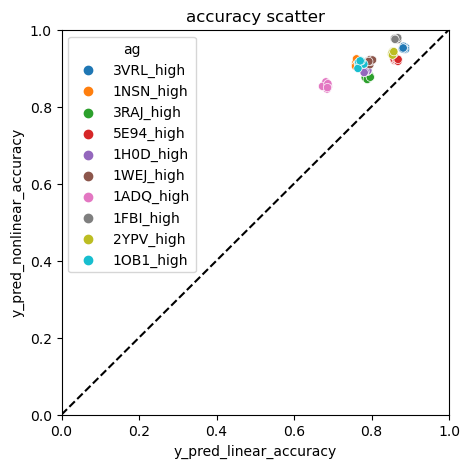

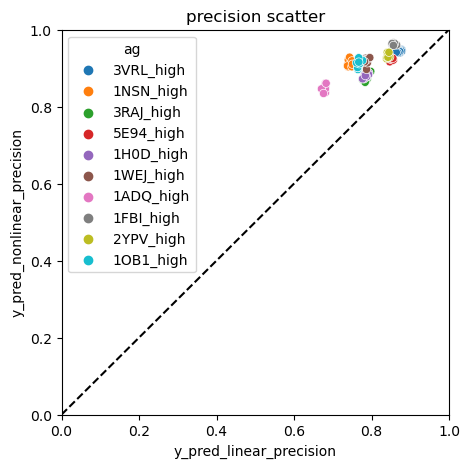

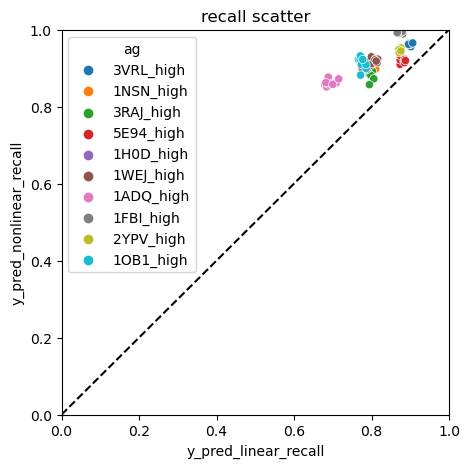

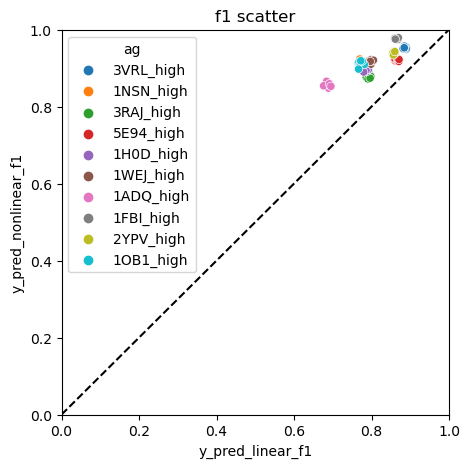

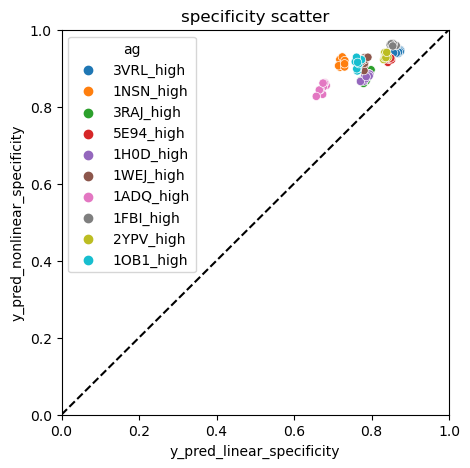

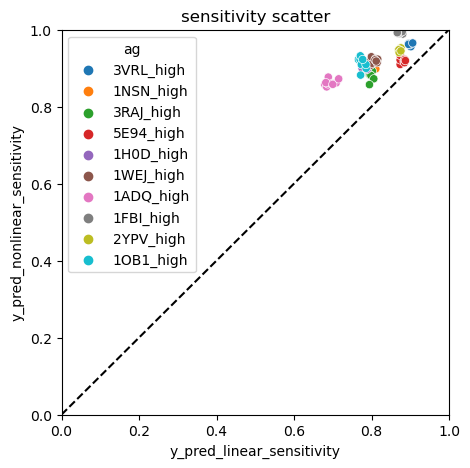

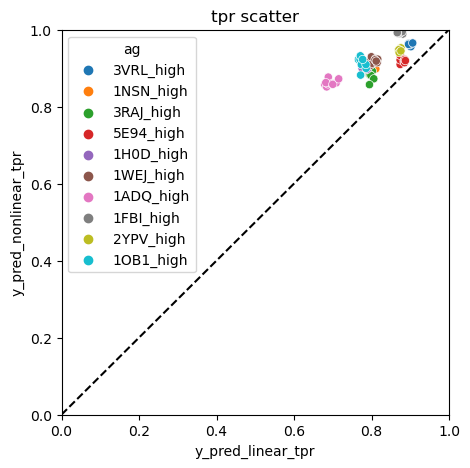

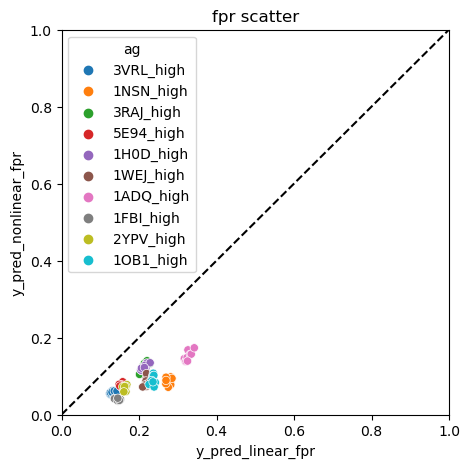

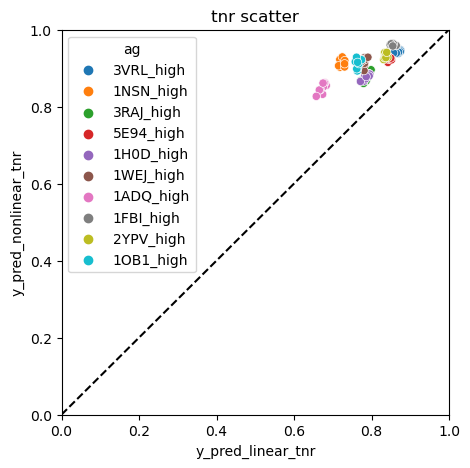

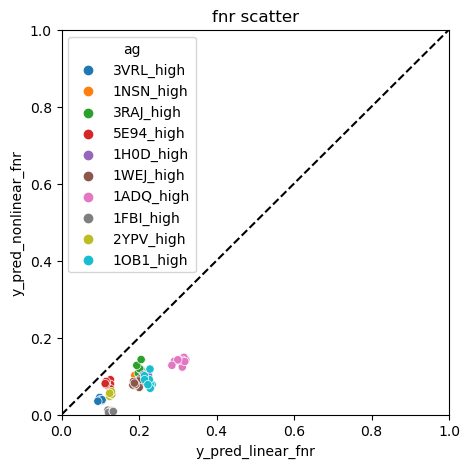

In [4]:
metrics = ["accuracy", "precision", "recall", "f1", "specificity", "sensitivity", "tpr", "fpr", "tnr", "fnr"]
for metric in metrics:
    df_metrics[f"{metric}_diff"] = df_metrics[f"y_pred_nonlinear_{metric}"] - df_metrics[f"y_pred_linear_{metric}"]
    
    # Plot scatter, hue by ag
    # Fix and same x-axis and y-axis, add diagonal
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=df_metrics, x=f"y_pred_linear_{metric}", y=f"y_pred_nonlinear_{metric}", hue="ag")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(f"{metric} scatter")
    plt.show()
    
    # # Plot histogram
    # plt.figure(figsize=(10, 5))
    # plt.hist(df_metrics[f"{metric}_diff"], bins=20)
    # plt.title(f"{metric} diff")
    # plt.show()

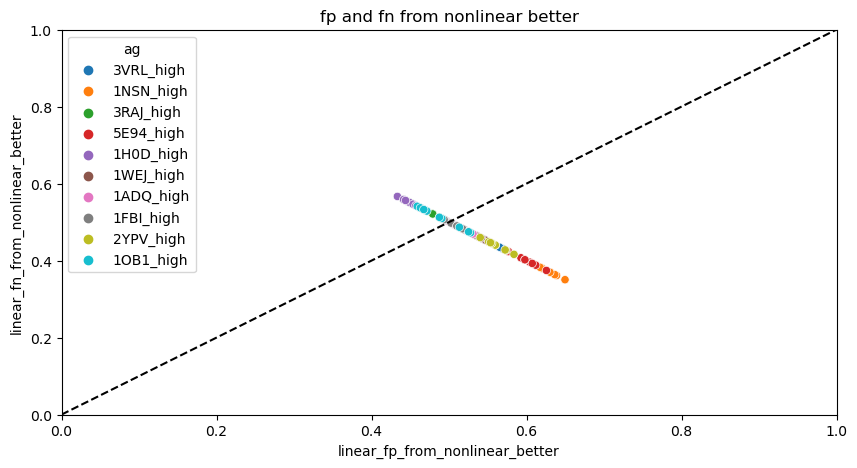

In [5]:
# Plot fp and fn from nonlinear better
# based on linear_fp_from_nonlinear_better	linear_fn_from_nonlinear_better
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_metrics, x="linear_fp_from_nonlinear_better", y="linear_fn_from_nonlinear_better", hue="ag")
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title(f"fp and fn from nonlinear better")
plt.show()    

# Compare directly the correlation with energy contributions

In [6]:
# tasks = list(utils_07.task_generator(task_types=(datasets.ClassificationTaskType.HIGH_VS_LOOSER,)))

In [7]:
# from utils_07 import (
#     load_energy_contributions_from_task_nonlinear_version,
#     load_energy_contributions_from_task_linear_version,
# )

# for task in tasks:

#     # Get linear
#     task_l = copy.deepcopy(task)
#     linear_loader = loader = datasets.FrozenMiniAbsolutMLLoader(
#         data_dir=Path("../data/Frozen_MiniAbsolut_Linear_ML/")
#     )
#     linear_loader.load(task_l, attributions_toload="v0.1.2-3")
#     stats_l, df_l = load_energy_contributions_from_task_linear_version(
#         task_l,
#         loader=linear_loader, 
#         load_slide_df=True)

#     # Get nonlinear
#     task_nl = copy.deepcopy(task)
#     nonlinear_loader = datasets.FrozenMiniAbsolutMLLoader(
#         data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
#     )
#     nonlinear_loader.load(task_nl, attributions_toload="v2.0-2")
#     stats_nl, df_nl = load_energy_contributions_from_task_nonlinear_version(
#         task_nl,
#         load_slide_df=True)
#     break

In [8]:
# df_l_nl = pd.merge(df_l, df_nl, on=["slide"], suffixes=["_linear", "_nonlinear"])

In [9]:
# (df_l_nl["r_total_nonlinear"] - df_l_nl["r_total_linear"]).sum()

In [10]:
# # Scatterplot of r_total_linear vs r_total_nonlinear
# plt.figure(figsize=(5, 5))
# sns.scatterplot(data=df_l_nl, x="r_total_linear", y="r_total_nonlinear")
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.plot([0, 1], [0, 1], color="black", linestyle="--")
# plt.title(f"r_total_linear vs r_total_nonlinear")
# plt.show()

In [11]:
# # T-test of r_total_linear vs r_total_nonlinear
# from scipy.stats import ttest_rel
# ttest_rel(df_l_nl["r_total_linear"], df_l_nl["r_total_nonlinear"])

# # Print averages
# print(df_l_nl["r_total_linear"].mean())
# print(df_l_nl["r_total_nonlinear"].mean())

Compute for all tasks

In [2]:
tasks = list(utils_07.task_generator())

In [3]:
FORCE_FLAG = False
path = "07f_df_energy_contrib_corr.csv"

records = []
failed_tasks = []

if Path(path).exists() and not FORCE_FLAG:
    df_energy_contrib_corr = pd.read_csv(path, index_col=None)
else:
    for task in tasks:

        print(f"Task: {task}")    
        try:
            # Get linear
            task_l = copy.deepcopy(task)
            linear_loader = loader = datasets.FrozenMiniAbsolutMLLoader(
                data_dir=Path("../data/Frozen_MiniAbsolut_Linear_ML/")
            )
            linear_loader.load(task_l, attributions_toload="v0.1.2-3")
            stats_l, df_l = utils_07.load_energy_contributions_from_task_linear_version(
                task_l,
                loader=linear_loader, 
                load_slide_df=True)

            # Get nonlinear
            task_nl = copy.deepcopy(task)
            nonlinear_loader = datasets.FrozenMiniAbsolutMLLoader(
                data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
            )
            nonlinear_loader.load(task_nl, attributions_toload="v2.0-2")
            stats_nl, df_nl = utils_07.load_energy_contributions_from_task_nonlinear_version(
                task_nl,
                load_slide_df=True)
        except:
            failed_tasks.append(task)
            continue
        
        df_l_nl = pd.merge(df_l, df_nl, on=["slide"], suffixes=["_linear", "_nonlinear"])
        
        # Compute correlation between r_total_linear and r_total_nonlinear
        # for the positive class
        corr_pos = df_l_nl.query("class_linear == 'positive'")["r_total_linear"].corr(df_l_nl["r_total_nonlinear"])
        corr_neg = df_l_nl.query("class_linear == 'negative'")["r_total_linear"].corr(df_l_nl["r_total_nonlinear"])
        corr_all = df_l_nl["r_total_linear"].corr(df_l_nl["r_total_nonlinear"])

        # Collect
        dataset_name = str(task)
        record = {
            "dataset_name": dataset_name,
            "r_total_corr_all": corr_all,
            "r_total_corr_pos": corr_pos,
            "r_total_corr_neg": corr_neg,
        }
        records.append(record)

    df_energy_contrib_corr = pd.DataFrame.from_records(records)
    df_energy_contrib_corr.to_csv(path, index=False)

In [4]:
df_energy_contrib_corr.head()

,dataset_name,r_total_corr_all,r_total_corr_pos,r_total_corr_neg
0,ONE_VS_NINE__3VRL__auto__0__42,0.825219,0.825219,NaN
1,HIGH_VS_95LOW__3VRL__auto__0__42,0.880372,0.914815,0.860912
2,HIGH_VS_LOOSER__3VRL__auto__0__42,0.870578,0.845629,0.888060
3,ONE_VS_NINE__3VRL__auto__1__42,0.791090,0.791090,NaN
4,HIGH_VS_95LOW__3VRL__auto__1__42,0.874077,0.911121,0.856108


In [5]:
# Annotate df with task_type and ag_pos
task_types = []
ag_pos = []
for task_str in df_energy_contrib_corr["dataset_name"].values:
    task = datasets.ClassificationTask.init_from_str(task_str)
    
    task_types.append(task.task_type.to_str())
    ag_pos.append(task.ag_pos)

df_energy_contrib_corr["task_type"] = task_types
df_energy_contrib_corr["ag_pos"] = ag_pos

In [6]:
df_energy_contrib_corr.head()

,dataset_name,r_total_corr_all,r_total_corr_pos,r_total_corr_neg,task_type,ag_pos
0,ONE_VS_NINE__3VRL__auto__0__42,0.825219,0.825219,NaN,1v9,3VRL
1,HIGH_VS_95LOW__3VRL__auto__0__42,0.880372,0.914815,0.860912,high_vs_95low,3VRL
2,HIGH_VS_LOOSER__3VRL__auto__0__42,0.870578,0.845629,0.888060,high_vs_looser,3VRL
3,ONE_VS_NINE__3VRL__auto__1__42,0.791090,0.791090,NaN,1v9,3VRL
4,HIGH_VS_95LOW__3VRL__auto__1__42,0.874077,0.911121,0.856108,high_vs_95low,3VRL


/tmp/ipykernel_3153022/2645234129.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], utils_07.task_order))


(0.0, 1.0)

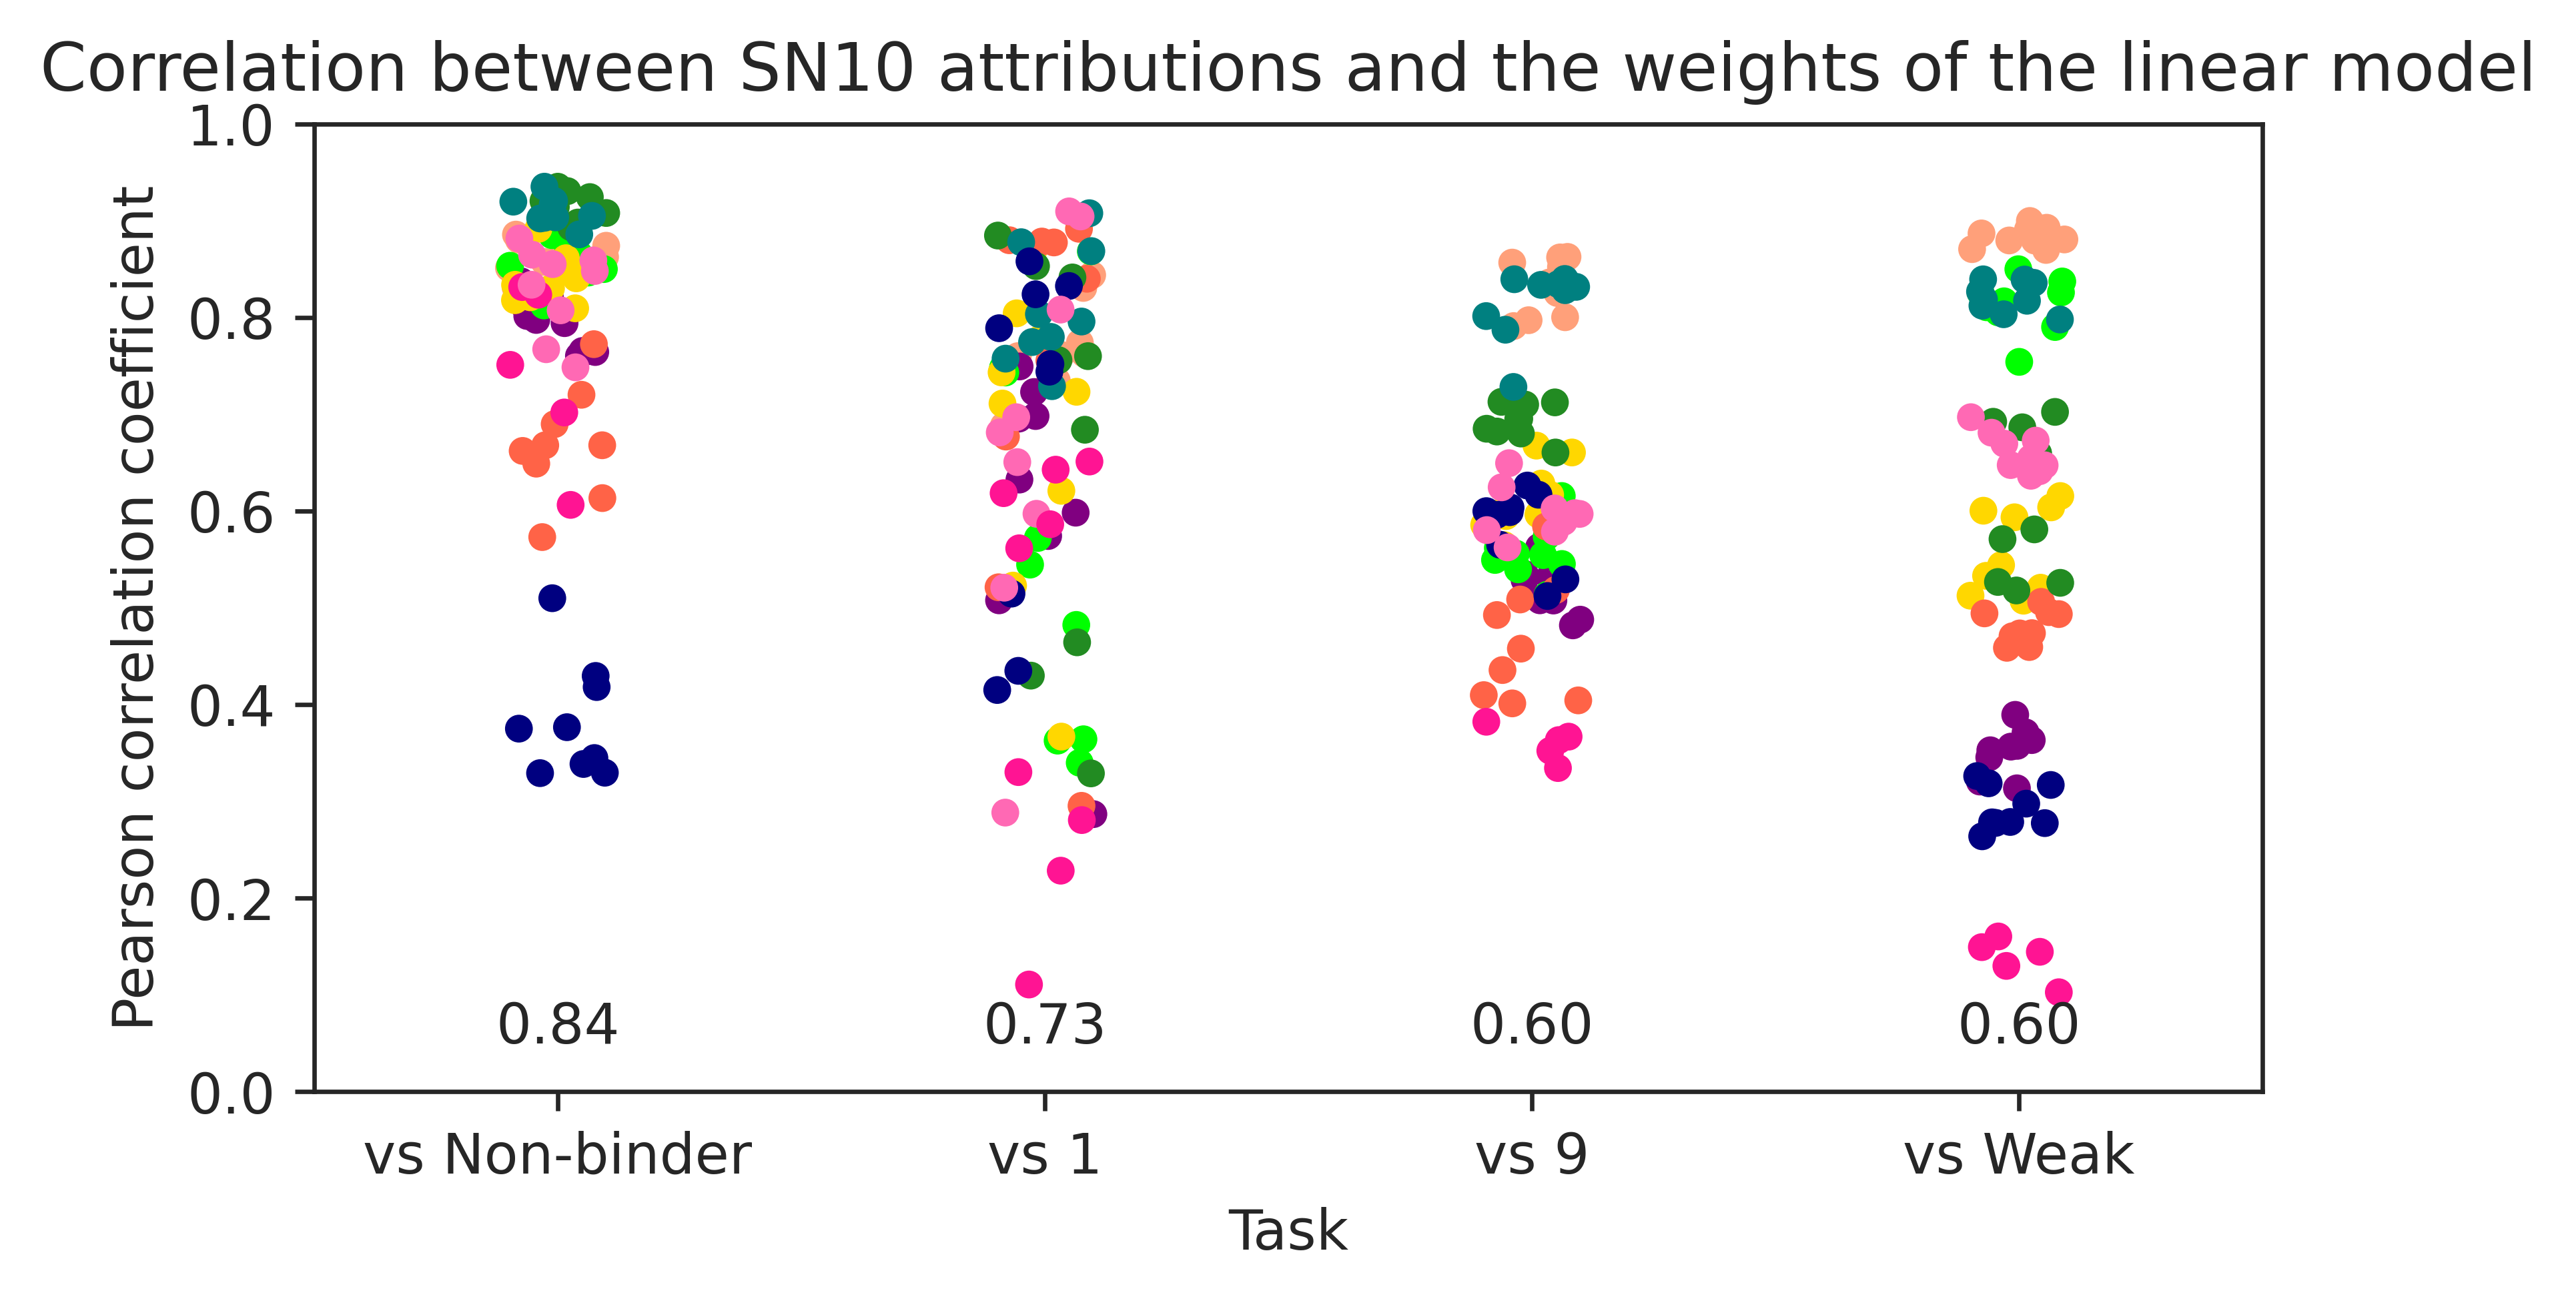

In [9]:
sns.set_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

sns.stripplot(
    data=df_energy_contrib_corr,
    x="task_type",
    y="r_total_corr_all",
    order=utils_07.task_order,
    hue="ag_pos",
    palette=utils_07.palette,
    ax=ax,
)

# Legend outside plot
ax.legend_.remove()  # type:ignore

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], utils_07.task_order))

# Add median r_pos per task
r_median_df = df_energy_contrib_corr.groupby(["task_type"]).agg({"r_total_corr_all": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,  # type:ignore
        0.05,
        f"{row['r_total_corr_all']:.2f}",
        # Center center
        horizontalalignment='center',
    )

ax.set_title("Correlation between SN10 attributions and the weights of the linear model")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")
ax.set_ylim(0, 1)

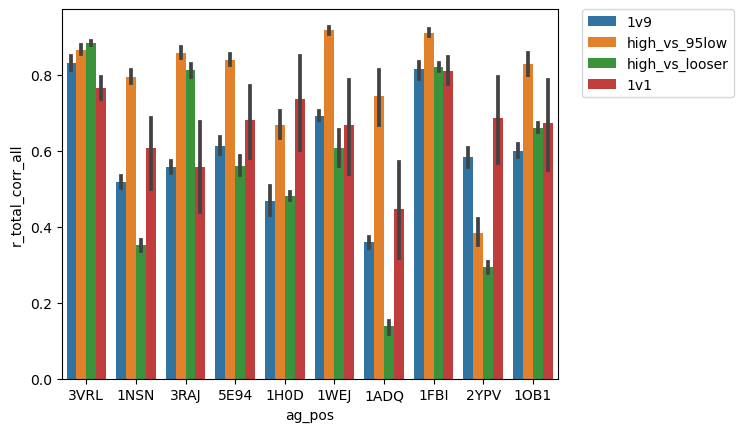

In [ ]:
sns.barplot(
    data=df_energy_contrib_corr,
    x="ag_pos",
    y="r_total_corr_all",
    hue="task_type",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Why there is no 1ADQ in 1v1 and why not so many data points in 1v1 in these plots, in comparison to Energies logits for nonlinear and linear?
1. Different Ag_pos and Ag_neg for linear and nonlinear?
    - we duplicated the ag_pos and ag_neg previously, but now that I'm thinking, for attributions it might be problematic to do it.
    - the performance might be symmetric to changing ag_pos and ag_neg in 1v1, but the attributions and other properties not necessarily!
    - => however we computed the attributions for both ways, need to double check!
2. Less models trained for 1v1 nonlinear? (But then, why we have many points in 07e for linear?)
    - Yes, since for nonlinear the computation of attributions is expensive. We computed for 1v1 only on one seed/split combination, for both ag_pos vs ag_neg and the other way around. For linear we computed for all splits and seeds (trivial extraction of wegihts).
3. Seed 0 and split 0-4 do not exist.


==> The problem with `1ADQ` was regarding no energy contributions data, leading to an error in the loader class.
==> Solved.